In [58]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [59]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
import xgboost as xgb
import random
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

In [60]:
trainSet = pd.read_csv("data/train_set_NOT_UNDER_num_cat_no_null.csv")
trainSet.head()

,person,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,...,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,label
0,0008ed71,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0
1,000c79fe,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
2,001802e4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,0
3,0019e639,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0
4,001b0bf9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [61]:
trainSet.shape

(19414, 2503)

#### SubMuestreo o undersample

0    18434
1      980
Name: label, dtype: int64


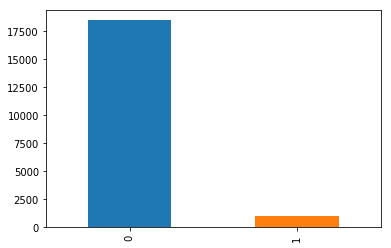

In [62]:
#Datos sin muestrear
import matplotlib.pyplot as plt
# graficos incrustados
%matplotlib inline
print trainSet['label'].value_counts()
trainSet['label'].value_counts().plot(kind= 'bar')

In [63]:
#1.Encuentra el número de muestras que son conversiones
# Genero una relacion 9 a 1 entre No-Conversiones y Conversiones
sizeConversiones = len(trainSet[trainSet['label'] == 1])*9 

In [64]:
#2. Obtener índices de muestras de no conversiones.
no_conversiones_indices = trainSet[trainSet.label == 0].index 

In [65]:
#Muestras aleatorias de índices de no conversiones.
#GENERO SEMILLA CON 3 PORQUE SI, EN REALIDAD PORQUE BRINDA UN NUMERO BAJO COMO 46
np.random.seed(3)
random_indices_no_conversiones = np.random.choice(no_conversiones_indices,sizeConversiones, replace=False)

In [66]:
#4. Encuentra los índices de muestras de conversiones.
conversiones = trainSet[trainSet.label == 1].index

In [67]:
#5. Índices de conversiones concat con muestras de no conversiones.
under_sample_indices = np.concatenate([conversiones,random_indices_no_conversiones])

In [68]:
#6 Obtener Balance Dataframe
under_sample = trainSet.loc[under_sample_indices]

In [69]:
under_sample = under_sample.sort_values(by='person')
under_sample['label'].value_counts()

0    8820
1     980
Name: label, dtype: int64

### Visualización de datos submuestreados

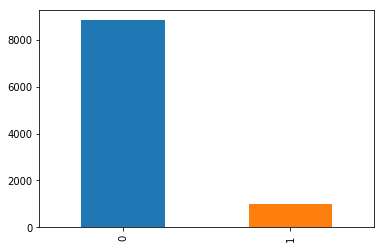

In [70]:
under_sample['label'].value_counts().plot(kind='bar')

Hiper-parámetros:

* **num_boost_round:** cantidad de árboles a contruir (n_estimators)
* **metrics:** la métrica de evaluación a utilizar

* **early_stopping_rounds:** terminar antes si la métrica no mejora luego de una cantidad de pasadas
* **seed:** semilla para poder reproducir los resultados

### COMIENZA LA BUSQUEDA DE PARAMETROS

In [71]:
trainSet.shape

(19414, 2503)

In [72]:
under_sample.shape

(9800, 2503)

In [73]:
target = 'label'
IDcol = 'person'

#Choose all predictors except target & IDcols
train = under_sample
predictors = [x for x in train.columns if x not in [target, IDcol]]

In [74]:
testSet = pd.read_csv("data/test_set_num_cat_no_null.csv").drop(columns = "Unnamed: 0")
print testSet.shape
testSet.head()

(19415, 2502)


,person,Enero_cantEventos,Enero_checkouts,Enero_leads,Enero_conversiones,Enero_staticPageVisitadas,Enero_ProductosVistosPorUser,Enero_productosBuscados,Enero_accesos por marketing online,Enero_searchEngine,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,00091926,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
1,00091a7a,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000ba417,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
3,000e4d9e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
4,000e619d,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


In [75]:
train.head()

,person,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,...,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,label
0,0008ed71,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0
1,000c79fe,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
6,001dfc31,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
7,001e9aea,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.5,0.5,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0
9,002b0188,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0


In [76]:
#VERIFICAMOS QUE LOS NOMBRES SON LOS MISMO, PERO EN DIFERENTE FORMATO. PROCEDEMOS A NORMALIZARLOS.
#prueba= train.columns.drop('label')
testSet.columns=train.columns.drop('label')
testSet.head()

,person,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,00091926,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
1,00091a7a,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000ba417,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
3,000e4d9e,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
4,000e619d,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


### FUNCIONES UTILIZADAS

In [77]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=30):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)

    

In [78]:
def modelfit2(alg, dtrain, predictors,dtest,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)
    
    #GRAFICO DE CURVA AUR-ROC PARA MOST-IMPORTANT
    #SOLO SE DEBE REEMPLAZAR LOS LABELS Y LAS PREDICCIONES EN roc_curve

    fpr, tpr, threshold = roc_curve(dtrain['label'].values, dtrain_predprob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(20,10))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of XGBOOST')
    plt.show()
    
    return dtest_predprob

### GENERAMOS UN MODELO CON DATOS COLOCADOS "A OJO"

In [79]:
xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=50,
 max_depth=3,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.35,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 seed=1024)


Model Report
Accuracy : 0.8127
AUC Score (Train): 0.861511


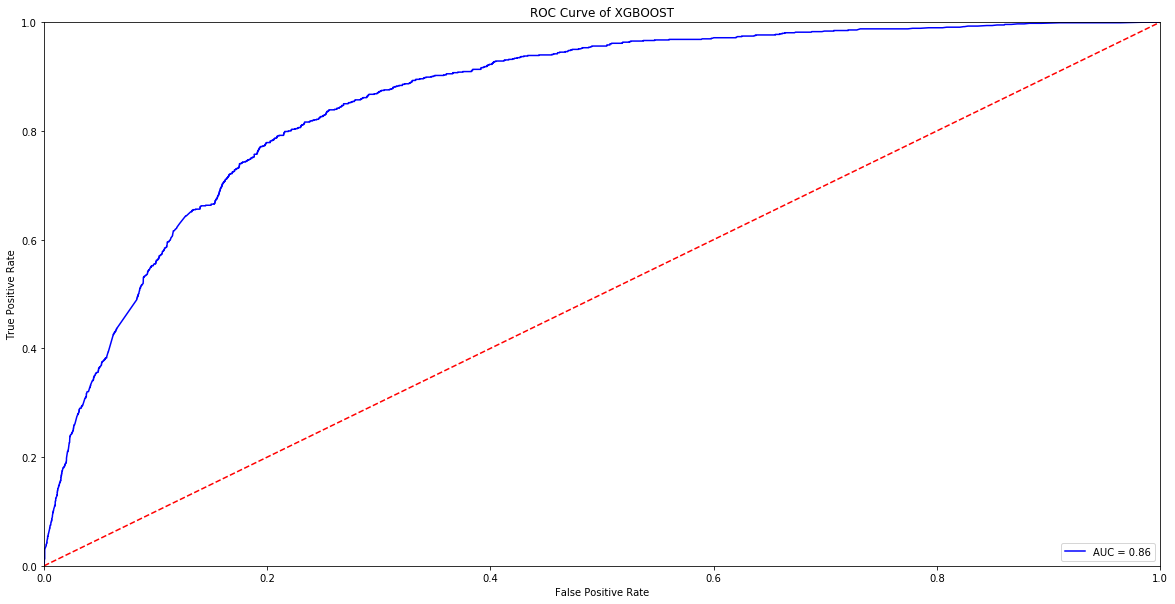

In [80]:
#GENERAMOS EL ARCHIVO CON PARAMETROS COLOCADOS A "OJO"
predict_base=modelfit2(xgb1, train, predictors,testSet)

In [81]:
df_base=pd.DataFrame({'person':testSet['person']})
df_base['label']=predict_base
df_base.head()

,person,label
0,00091926,0.420333
1,00091a7a,0.618111
2,000ba417,0.497317
3,000e4d9e,0.459961
4,000e619d,0.476844


In [82]:
df_base.to_csv('submit_kaggle/sub20_base_modelo3_xGBoost_9a1.csv', index=False)

### COMENZAMOS CON EL TUNING DE LOS PARAMETROS

In [83]:
#SITUACION INICIAL
param_test0 = {
 'n_estimators':[50],#range(50, 400, 50),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=50, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84487, std: 0.00803, params: {'n_estimators': 50}],
 {'n_estimators': 50},
 0.8448652760423897)

In [84]:
#BUSCAMOS CUANTOS ARBOLES GENERAR PARA LAS PRUEBAS
param_test0 = {
 'n_estimators':range(50, 400, 50),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=50, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84487, std: 0.00803, params: {'n_estimators': 50},
  mean: 0.84580, std: 0.00821, params: {'n_estimators': 100},
  mean: 0.84460, std: 0.00740, params: {'n_estimators': 150},
  mean: 0.84312, std: 0.00704, params: {'n_estimators': 200},
  mean: 0.83979, std: 0.00635, params: {'n_estimators': 250},
  mean: 0.83730, std: 0.00626, params: {'n_estimators': 300},
  mean: 0.83583, std: 0.00677, params: {'n_estimators': 350}],
 {'n_estimators': 100},
 0.8458020963487437)

In [85]:
#SE CONTINUA CON LA BUSQUEDA DE max_depth Y min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(4,8,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84686, std: 0.00801, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.84738, std: 0.00696, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.84156, std: 0.00702, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.84274, std: 0.00825, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.83993, std: 0.00781, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.84205, std: 0.00769, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: 0.83465, std: 0.00624, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: 0.83680, std: 0.00831, params: {'max_depth': 9, 'min_child_weight': 6}],
 {'max_depth': 3, 'min_child_weight': 6},
 0.8473807209958814)

In [86]:
# SE ENCUENTRAN LOS PARAMETROS ADECUADOS PARA max_depth Y min_child_weight
param_test2 = {
 'min_child_weight':[6,7,8]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84738, std: 0.00696, params: {'min_child_weight': 6},
  mean: 0.84774, std: 0.00717, params: {'min_child_weight': 7},
  mean: 0.84765, std: 0.00740, params: {'min_child_weight': 8}],
 {'min_child_weight': 7},
 0.8477411032440187)

In [87]:
# SE HALLA EL PARAMETRO ADECUADO PARA gamma
param_test3 = {
 'gamma':[0,0.1,0.2]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84774, std: 0.00717, params: {'gamma': 0},
  mean: 0.84774, std: 0.00717, params: {'gamma': 0.1},
  mean: 0.84774, std: 0.00717, params: {'gamma': 0.2}],
 {'gamma': 0},
 0.8477411032440187)

In [88]:
# SE COMIENZA CON LA BUSQUEDA DE subsample Y colsample_bytree
param_test4 = {
 'subsample':[0.2,0.35,0.8],
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.84355, std: 0.00719, params: {'subsample': 0.2},
  mean: 0.84596, std: 0.00858, params: {'subsample': 0.35},
  mean: 0.84774, std: 0.00717, params: {'subsample': 0.8}],
 {'subsample': 0.8},
 0.8477411032440187)

In [89]:
# FINALMENTE SE ENCUENTRAN LOS PARMETROS ADECUADOS PARA subsample Y colsample_bytree
param_test5 = {
 'colsample_bytree':[0.3,0.35],
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.2,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84813, std: 0.00693, params: {'colsample_bytree': 0.3},
  mean: 0.84774, std: 0.00717, params: {'colsample_bytree': 0.35}],
 {'colsample_bytree': 0.3},
 0.8481275163126476)

In [90]:
# SE REALIZA LA BUSQUEDA DE reg_alpha
param_test6 = {
 'reg_alpha':[0,1e-5,1e-4,1e-3,1e-2]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84813, std: 0.00693, params: {'reg_alpha': 0},
  mean: 0.84813, std: 0.00693, params: {'reg_alpha': 1e-05},
  mean: 0.84813, std: 0.00693, params: {'reg_alpha': 0.0001},
  mean: 0.84813, std: 0.00693, params: {'reg_alpha': 0.001},
  mean: 0.84805, std: 0.00687, params: {'reg_alpha': 0.01}],
 {'reg_alpha': 0},
 0.8481275163126476)

### POR ULTIMO BUSCAMOS LOS VALORES FINALES PARA n_estimators Y learning_rate

In [91]:
param_test0 = {
 'n_estimators':[700],
 'learning_rate':[0.0001]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.83998, std: 0.00916, params: {'n_estimators': 700, 'learning_rate': 0.0001}],
 {'learning_rate': 0.0001, 'n_estimators': 700},
 0.8399836295062242)

In [93]:
param_test0 = {
 'n_estimators':[1000],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84634, std: 0.00575, params: {'n_estimators': 1000, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 1000},
 0.8463374635568514)

In [94]:
param_test0 = {
 'n_estimators':[800],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84868, std: 0.00630, params: {'n_estimators': 800, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 800},
 0.8486842866398259)

In [95]:
param_test0 = {
 'n_estimators':[850],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84819, std: 0.00609, params: {'n_estimators': 850, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 850},
 0.8481879656624555)

In [96]:
param_test0 = {
 'n_estimators':[825],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024),
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84852, std: 0.00618, params: {'n_estimators': 825, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 825},
 0.848517110926003)

# FINALMENTE VERIFICAMOS LOS PARAMETROS OBTENIDOS

In [97]:
# PARAMETROS INICIAL
param_test0 = {
 'n_estimators':[50],
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=50, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.35,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84487, std: 0.00803, params: {'n_estimators': 50}],
 {'n_estimators': 50},
 0.8448652760423897)

In [100]:
#PARAMETROS CON TUNING1
param_test0 = {
 'n_estimators':[100],
 'learning_rate':[0.05]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84813, std: 0.00693, params: {'n_estimators': 100, 'learning_rate': 0.05}],
 {'learning_rate': 0.05, 'n_estimators': 100},
 0.8481275163126476)

In [99]:
#PARAMETROS CON TUNING
param_test0 = {
 'n_estimators':[800],
 'learning_rate':[0.01]
}
gsearch0 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.05, n_estimators=100, max_depth=3,
 min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.3,reg_alpha= 0.011,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=9, seed=1024), 
 param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch0.fit(train[predictors],train[target])
gsearch0.grid_scores_, gsearch0.best_params_, gsearch0.best_score_

([mean: 0.84868, std: 0.00630, params: {'n_estimators': 800, 'learning_rate': 0.01}],
 {'learning_rate': 0.01, 'n_estimators': 800},
 0.8486842866398259)


Model Report
Accuracy : 0.8267
AUC Score (Train): 0.884061


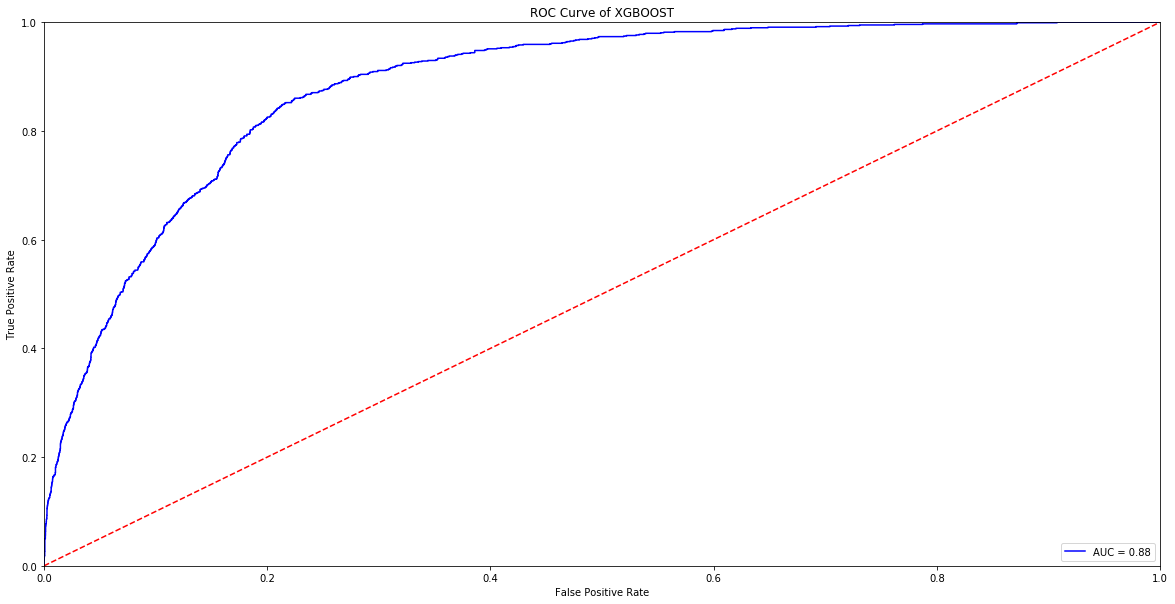

array([0.2476794 , 0.69317055, 0.41440588, ..., 0.5954293 , 0.5814856 ,
       0.1496526 ], dtype=float32)

In [103]:
# COMO HEMOS TENIDO UN RESULTADO SE GENERO UNA MAYOR CANTIDAD DE ARBOLES Y SE ENTRENO EL NUEVO MODELO
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=7,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=6, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)
modelfit2(xgb2, train, predictors,testSet)

# FINALMENTE CON EL MEJOR MODELO REALIZAMOS LAS PREDICCIONES

In [104]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=7,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)


Model Report
Accuracy : 0.8036
AUC Score (Train): 0.885007


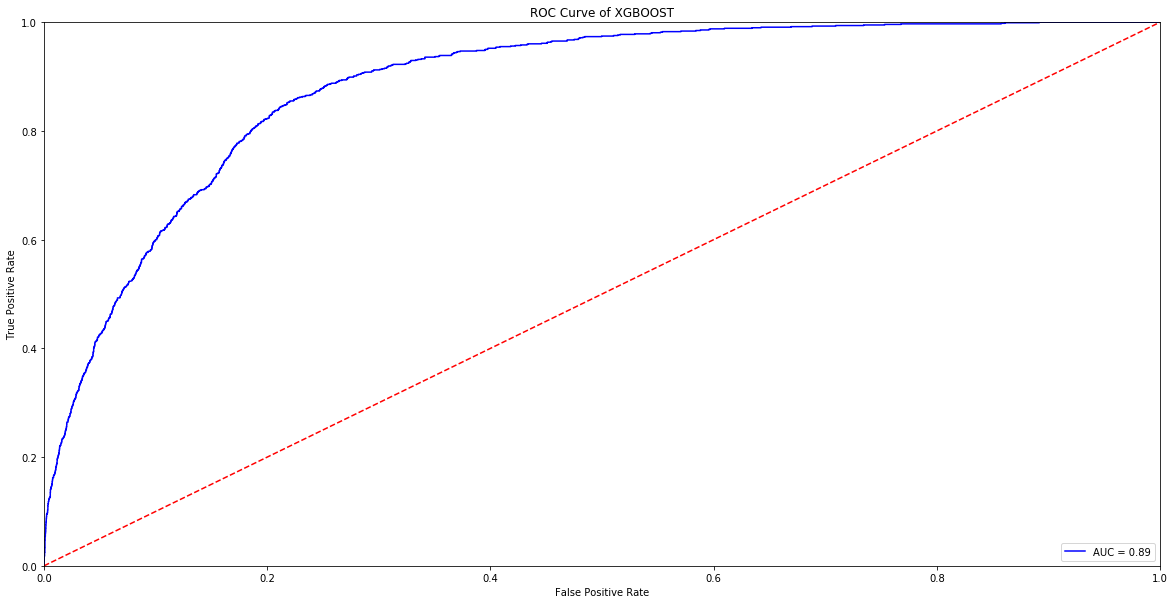

In [105]:
predict_test_tuning=modelfit2(xgb2, train, predictors,testSet)

In [106]:

df_prueba_tuning=pd.DataFrame({'person':testSet['person']})
df_prueba_tuning['label']=predict_test_tuning
df_prueba_tuning.head()


,person,label
0,00091926,0.333588
1,00091a7a,0.772526
2,000ba417,0.520818
3,000e4d9e,0.434658
4,000e619d,0.512722


In [107]:
df_prueba_tuning.to_csv('submit_kaggle/sub20_modelo3_xGBoost_tuning_9a1.csv', index=False)

# INTENTAREMOS MEJORAR NUESTRA PREDICIONES TRABAJANDO AUN MAS CON LOS DATOS, ESTANDARIZAMOS LOS MISMOS.

### ESTANDARIZO LAS MATRICES

In [110]:
features=train.iloc[:,1:]
features=features.iloc[:,:-1]
feature_list = list(features.columns)
print features.shape
features.head()

(9800, 2501)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.5,-0.5,0.5,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


In [111]:
#NORMALIZO EL DF Y VERIFICO QUE NO HAYA NaN

# Get column names first
names = features.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()#MinMaxScaler()#Normalizer()#StandardScaler()

# Fit your data on the scaler object
scaled_df = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_df, columns=names)
print scaled_df.shape
features=scaled_df
features_under_sample_std=scaled_df
print ("Hay Null: ",features.isnull().values.any())
scaled_df.head()

(9800, 2501)
('Hay Null: ', False)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-2.447121,-2.426629,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530
1,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.481011,0.484382,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
2,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.481011,0.484382,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
3,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.983055,-0.971123,-0.242913,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258
4,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-2.447121,-2.426629,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530


In [112]:
train_scaled_person=pd.DataFrame({'person':train['person']}).reset_index().drop('index',1)
train_scaled_person.head()

,person
0,0008ed71
1,000c79fe
2,001dfc31
3,001e9aea
4,002b0188


In [113]:
train_scaled_label=pd.DataFrame({'label':train['label']}).reset_index().drop('index',1)
train_scaled_label.head()

,label
0,0
1,0
2,0
3,0
4,0


In [114]:
train_scaled=scaled_df.loc[:,:]
train_scaled['person']=train_scaled_person['person']
train_scaled['label']=train_scaled_label['label']
train_scaled.head(15)

,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,person,label
0,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,0008ed71,0
1,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,000c79fe,0
2,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,001dfc31,0
3,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.242913,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,001e9aea,0
4,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.891250,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,002b0188,0
5,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,2.998771,-0.056716,2.831697,0.262177,0.883097,-0.908229,-0.880242,-1.021258,003476c0,1
6,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,003847fc,0
7,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,0.883097,-0.908229,-0.880242,-1.021258,003a7d49,0
8,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,0.405424,-0.056716,-0.376321,0.262177,-1.021443,1.127955,1.164207,0.985530,003bdb4d,0
9,-0.123665,-0.08702,-0.027115,-0.017499,-0.046383,-0.05447,-0.048925,-0.049735,-0.115781,-0.094516,...,-0.891250,-0.056716,-0.376321,-3.727479,0.883097,-0.908229,-0.880242,0.985530,003d4cac,1


In [115]:
features_test=testSet.iloc[:,1:]
feature_list = list(features_test.columns)
print features_test.shape
features_test.head()

(19415, 2501)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0


In [116]:
#NORMALIZO EL DF Y VERIFICO QUE NO HAYA NaN

# Get column names first
names = features_test.columns

# Create the Scaler object
scaler = preprocessing.StandardScaler()#MinMaxScaler()#Normalizer()#StandardScaler()

# Fit your data on the scaler object
scaled_df = scaler.fit_transform(features_test)
scaled_df = pd.DataFrame(scaled_df, columns=names)
print scaled_df.shape
features_test=scaled_df
print ("Hay Null: ",features_test.isnull().values.any())
scaled_df.head()

(19415, 2501)
('Hay Null: ', False)


,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh81-Mayo,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo
0,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,3.011501,-0.057554,2.780762,0.249683,-1.020763,1.128591,1.159879,0.991185
1,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,-0.906760,-0.057554,-0.383098,-3.802864,0.885495,-0.909337,-0.884952,0.991185
2,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185
3,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185
4,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.477195,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185


In [117]:
scaled_df['person']=testSet['person']
test_scaled=scaled_df.loc[:,:]
test_scaled.head()

,Enero - cantidadEventos,Enero - checkouts,Enero - leads,Enero - conversiones,Enero - staticPageVisitadas,Enero - ProductosVistosPorUser,Enero - productosBuscados,Enero - accesos por marketing online,Enero - searchEngine,Enero - accesos a la homepage,...,F13_region_fh82-Mayo,F13_region_fh83-Mayo,F13_region_fh84-Mayo,F13_region_fh85-Mayo,F13_device_type_fh1-Mayo,F13_device_type_fh2-Mayo,F13_device_type_fh3-Mayo,F13_device_type_fh4-Mayo,F13_device_type_fh5-Mayo,person
0,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,3.011501,-0.057554,2.780762,0.249683,-1.020763,1.128591,1.159879,0.991185,00091926
1,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,-0.906760,-0.057554,-0.383098,-3.802864,0.885495,-0.909337,-0.884952,0.991185,00091a7a
2,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185,000ba417
3,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185,000e4d9e
4,-0.12291,-0.081738,-0.036141,-0.018991,-0.036603,-0.057364,-0.042405,-0.049172,-0.120021,-0.096622,...,0.48047,0.399327,-0.057554,-0.383098,0.249683,-1.020763,1.128591,1.159879,0.991185,000e619d


# FINALMENTE CON LOS VALORES DE LOS HIPERPARAMETROS OBTENIDOS CONSTRUIMOS EL MODELO


Model Report
Accuracy : 0.8036
AUC Score (Train): 0.885007


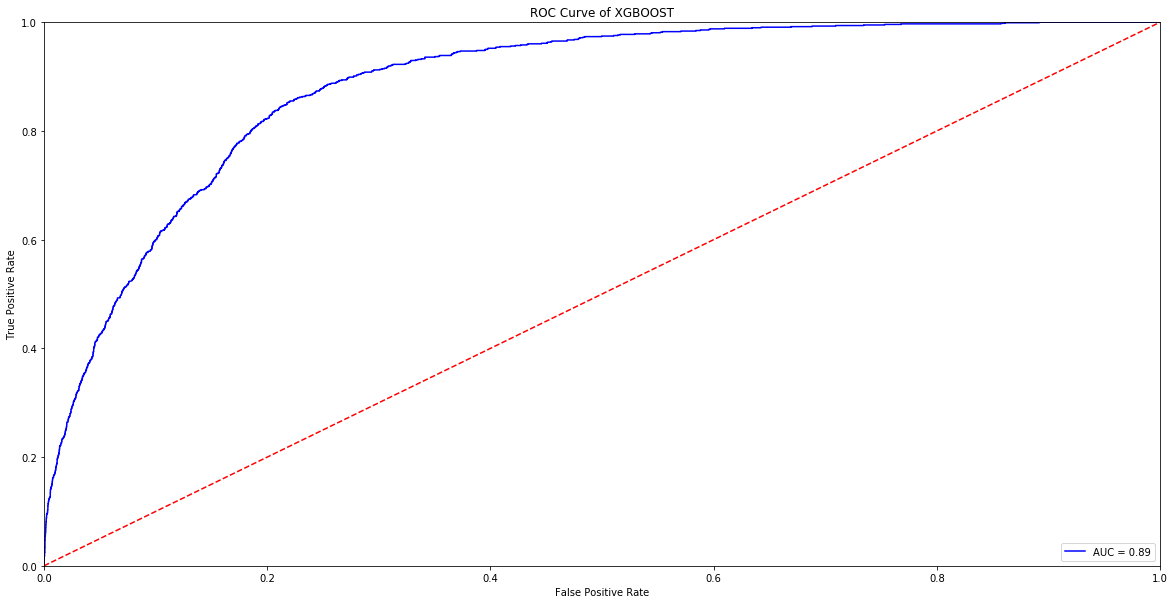

In [119]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=800,
 max_depth=3,
 min_child_weight=7,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=9, #2940/980=3
 reg_alpha= 0.011,
 seed=1024)
predict_test_final_std=modelfit2(xgb2, train_scaled, predictors,test_scaled)

In [120]:
df_test_final_std=pd.DataFrame({'person':testSet['person']})
df_test_final_std['label']=predict_test_final_std
df_test_final_std.head(25)


,person,label
0,00091926,0.333589
1,00091a7a,0.770440
2,000ba417,0.520819
3,000e4d9e,0.429172
4,000e619d,0.510670
5,001001be,0.301590
6,0010e89a,0.106271
7,0016c4b5,0.079590
8,001804a2,0.249722
9,001a2273,0.092146


In [121]:
#VERIFICAMOS PREDICCIONES FINALES STD
np.around(df_test_final_std['label']).value_counts()

0.0    14780
1.0     4635
Name: label, dtype: int64

In [122]:
#VERIFICAMOS PREDICCIONES ANTERIORES SIN STD
np.around(df_prueba_tuning['label']).value_counts()

0.0    14783
1.0     4632
Name: label, dtype: int64

In [123]:
#VERIFICAMOS EN CUANTO DIFIERE LA CLASIFICACION DE AMBOS MODELOS
abs(np.around(df_prueba_tuning['label'])-np.around(df_test_final_std['label'])).sum()

19.0

In [124]:
#NOS QUEDAMOS CON EL MODELO STANDARIZADO
df_test_final_std.to_csv('submit_kaggle/sub20_modelo3_xGBoost_9a1_std.csv', index=False)